In [0]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
import pandas as pd
import random
import itertools
from scipy.sparse import csr_matrix

In [0]:
file = open('The Fellowship Of The Ring.txt', "r", encoding='utf-8', errors='ignore')
with file as f:
    filedata = f.read()
sentences = [sentence.replace("[^a-zA-Z]", " ") for sentence in filedata.split('.')]
#splits sentences into list of words (for co-occurrence matrix)
words_in_sentences = [sentence.split(" ") for sentence in sentences]

In [0]:
#base SpaCy NER algorithm:
nlp = en_core_web_sm.load()

#increasing maximum text length since LOTR books are LONG!
nlp.max_length = len(filedata)

#Function to output a dataframe with entities and their predicted labls
def run_spacy(nlp):
  doc = nlp(filedata)
  entities = [(X.text, X.label_) for X in doc.ents]
  ner_df = pd.DataFrame({'text':[x[0] for x in entities],'label':[x[1] for x in entities]}).drop_duplicates(subset='text')
  return ner_df

In [8]:
ner_df = run_spacy(nlp) 
characters = ner_df.loc[ner_df['label']=='PERSON','text'].reset_index(0)
print(characters)

     index         text
0       17      Gandalf
1       26        Balin
2       29    Lothlrien
3       35          III
4       45  Christopher
..     ...          ...
419   9677          Hen
420   9686       Burden
421   9782         Whoa
422   9795       Coming
423   9828     Mr Frodo

[424 rows x 2 columns]


Training SpaCy for Characters

In [9]:
full_characters = pd.read_csv('LOTR_characters.csv')
print(full_characters.head())

         Name                                     Url   Race
0      Adanel      http://lotr.wikia.com//wiki/Adanel  Human
1   Adrahil I   http://lotr.wikia.com//wiki/Adrahil_I  Human
2  Adrahil II  http://lotr.wikia.com//wiki/Adrahil_II  Human
3      Aegnor      http://lotr.wikia.com//wiki/Aegnor    Elf
4       Aerin       http://lotr.wikia.com//wiki/Aerin  Human


In [0]:
#Selecting only first name from name column of full character list since most
#sentences in text will only refer to the character by one name.
full_characters['first'], full_characters['last'] = full_characters['Name'].str.split(' ', 1).str
#replacing stopword "The" first name with the full last name
full_characters.loc[full_characters['first']=='The','first'] = full_characters.loc[full_characters['first']=='The','last']

In [0]:
#Creating training dataset in the format that spacy likes: sentence, (index_start, index_end, entity type)
train_data = [(sent, {'entities':[(sent.find(name),sent.find(name)+len(name),'PERSON')]}) \
              if sent.find(name) != -1 else '' \
              for name in full_characters['first'].values for sent in sentences]

#Removing blank items (sentences without the looked-for character's name)
train_data = [item for item in train_data if item]

In [12]:
#print an example
print(train_data[100])

(" Put me down! '\n     Aragorn nearly dropped him in his amazement", {'entities': [(21, 28, 'PERSON')]})


In [13]:
#Size of training dataset
print(len(train_data))

6806


In [14]:
print(len(sentences))

11504


In [15]:
#Reference: https://spacy.io/usage/training#ner
def train_spacy(data,iterations):
    # Create an empty model with English vocabulary
    nlp = spacy.blank('en')

    # Adding the pre-trained entity recognizer to the pipeline
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner, last=True)

    # Check to make sure there are no other pipes we need to freeze
    print(nlp.pipe_names)

    # Add labels to NER pipe with a generator expression
    for _,annotation in data:
      ner.add_label(annotation['entities'][0][2])

    # Train NER pipe
    optimizer = nlp.begin_training()
    for itn in range(iterations):
        print("Starting iteration " + str(itn))
        #shuffle order of training set to reduce overfitting
        random.shuffle(data)
        losses = {}
        for text, annotations in data:
            nlp.update(
                [text],  # sentences
                [annotations],  # entity label and location
                #update ner layer weights with stochastic gradient descent
                sgd=optimizer,
                #setting 20% dropout rate for neurons
                drop = 0.2,
                #using multi-label log-loss function. Closer to zero = better
                losses=losses)
        print(losses)
    return nlp

#Only running 10 iterations to avoid overfitting
char_nlp = train_spacy(train_data, 10)
# Save the trained model
char_nlp.to_disk('Character_trained_NER')

['ner']
Starting iteration 0


KeyboardInterrupt: ignored

## Evaluating NER on Lord of the Rings

Base Model

In [0]:
#creates a co-occurrence matrix for characters present with each other in each sentence.
#Example: "Gandalf and Merry went on a walk" Matrix['Gandalf']['Merry'] += 1
def create_co_occurence_matrix(characters, sentences):
    #indexing characters
    word_to_id = dict(zip(characters, range(len(characters))))
    #returns list of lists: ids of characters found in each sentence
    sentences_as_ids = [np.sort([word_to_id[w] for w in sentence if w in word_to_id]).astype('uint32') for sentence in sentences]
    #creating a pair of indices for each character found in the sentence
    #row_ind = sentence index. col_ind = character_index
    row_ind, col_ind = zip(*itertools.chain(*[[(i, w) for w in sentence] for i, sentence in enumerate(sentences_as_ids)]))
    #data is binary: did the character appear in the sentence or not?
    #since this must be true for every (row_ind, col_ind), set value to 1
    data = np.ones(len(row_ind), dtype='uint32')
    #determining dimension of square matrix (equal to len(characters) if all are found in sentences)
    max_word_id = max(itertools.chain(*sentences_as_ids)) + 1
    #using CSR matrix for efficient matrix storage and multiplication.
    #Each cell in a row = 1 if the tuple coordinates are in zip(row_ind, col_ind)
    #else, cell value = 0
    sentence_words_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(len(sentences_as_ids), max_word_id))
    #matrix algebra: multiply transpose of sentence words matrix by itself: gives dimension words by words
    words_cooc_matrix = sentence_words_matrix.T * sentence_words_matrix 
    #we don't care about a character co-occurring with itself (since it does in every relevant sentence)
    words_cooc_matrix.setdiag(0)
    return words_cooc_matrix, word_to_id 

In [0]:
#Outputs a plot of the top n characters ranked in descending order of importance based on each centrality metric
def character_importance(key, centrality_dict, word_mapping, n):
  char_importance = pd.DataFrame.from_dict(centrality_dict[key], orient='index')
  char_importance['name'] = word_mapping.keys()
  char_importance = char_importance.sort_values(by=0, ascending=False).iloc[:n,:].sort_values(by=0, ascending=True)
  fig = plt.figure(figsize=(20,10))
  plt.barh(char_importance['name'], char_importance[0], align='center')
  plt.title('SpaCy Character {}'.format(key))
  plt.show()

In [0]:
def visualize(co_mat, word_mapping, n):
  #Abstract art: networks visualization of the relationships between characters.
  G = nx.from_numpy_matrix(co_mat.toarray(), create_using=nx.DiGraph)
  layout = nx.circular_layout(G)
  nx.draw_networkx_labels(G, nx.circular_layout(G))
  nx.draw_networkx_edges(G, nx.circular_layout(G))
  plt.show()

  #Calculating the 4 types of centrality
  bc = nx.betweenness_centrality(G, normalized=False)
  dc = nx.degree_centrality(G)
  cc = nx.closeness_centrality(G)
  ec = nx.eigenvector_centrality(G)
  #Running through each of the types
  centrality_dict = {'Betweenness Centrality':bc,'Degree Centrality':dc,'Closeness Centrality':cc,'Eigenvector Centrality':ec}
  for key in centrality_dict.keys():
    character_importance(key, centrality_dict, word_mapping, n)


423


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


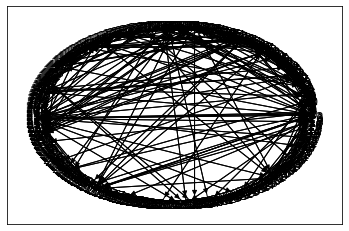

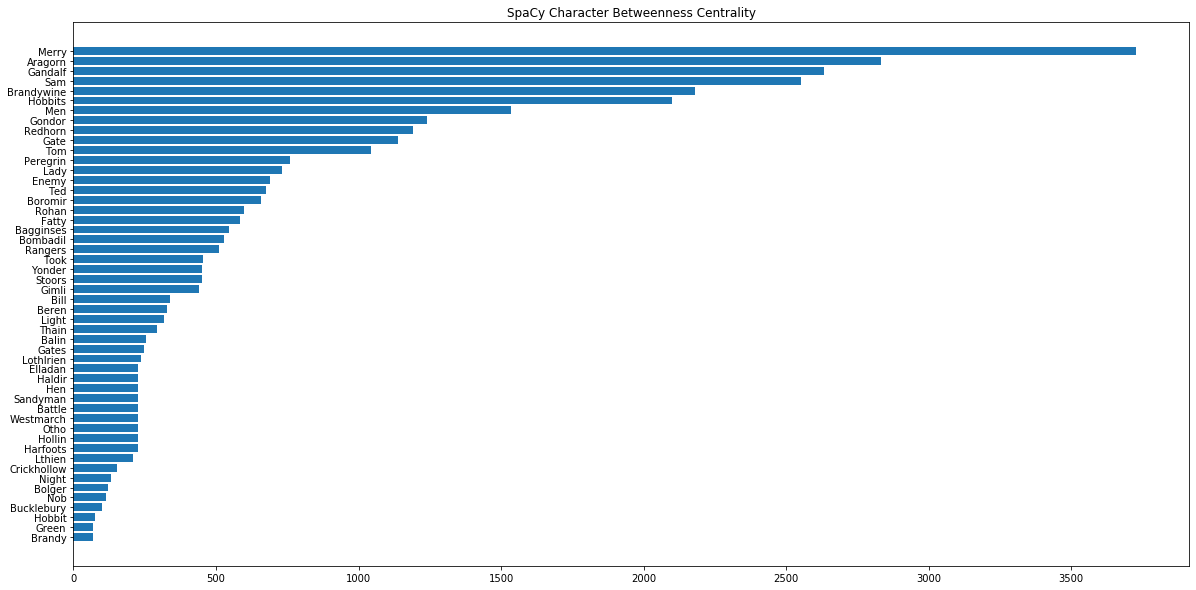

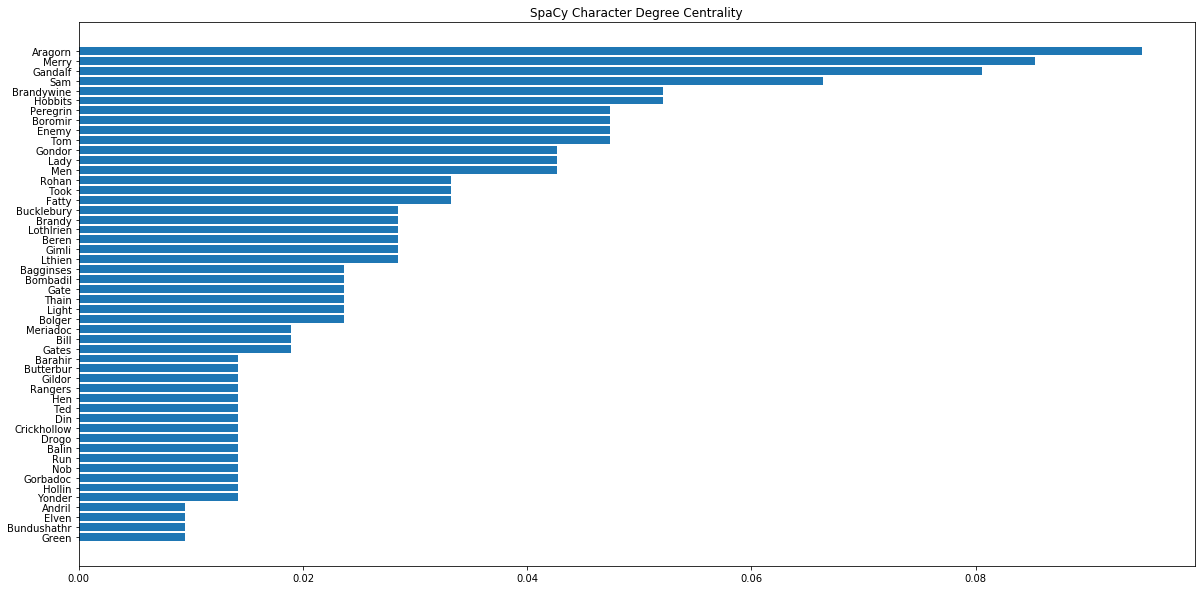

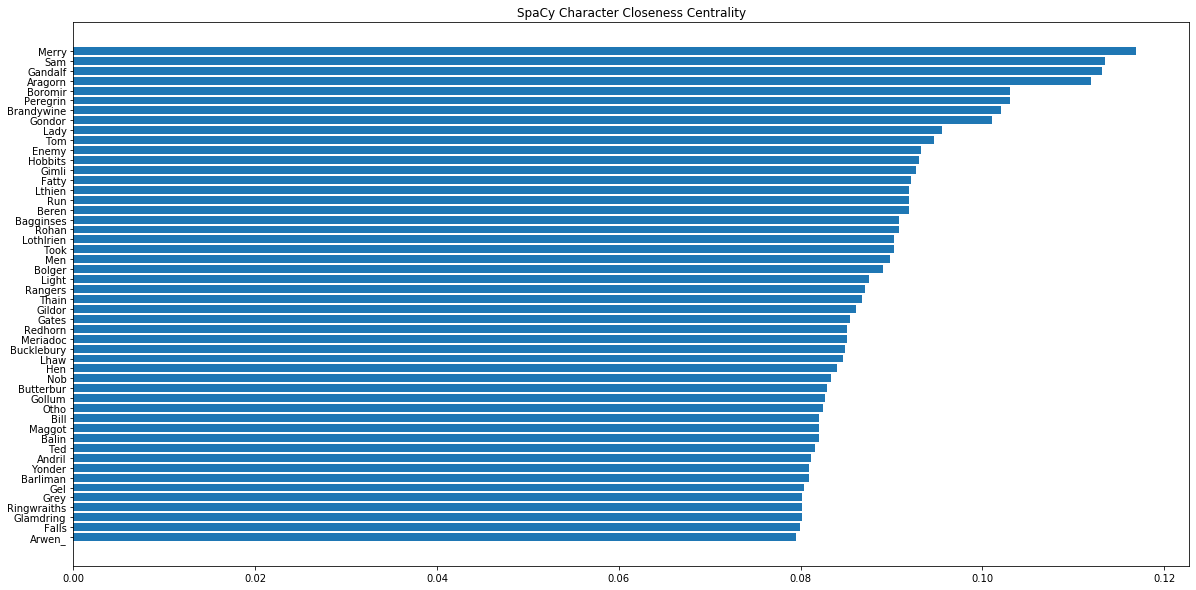

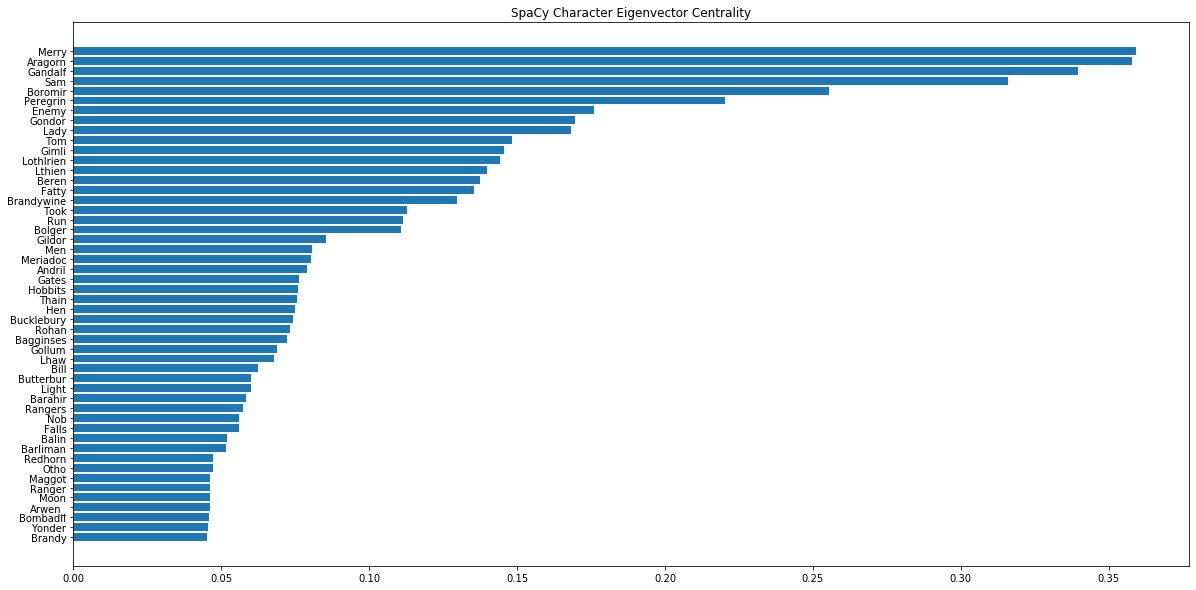

In [0]:
#Base Spacy Model results
co_mat, word_mapping = create_co_occurence_matrix(characters['text'].values, words_in_sentences)
visualize(co_mat, word_mapping)

Trained Model Results

In [0]:
char_nlp = spacy.load('Character_trained_NER')
char_nlp.max_length = len(filedata)
ner_df_char = run_spacy(char_nlp)

In [17]:
trained_characters = ner_df_char.loc[ner_df_char['label']=='PERSON','text'].reset_index(0)
#Dropping non-character first names
trained_characters = trained_characters[~trained_characters['text'].isin(['Old','Mount','Master','Miserable','Horsemen'])].reset_index(0)['text']
#Adding Sam as a character (Samwise Gamgee referred to by nickname)
trained_characters.loc[len(trained_characters)] = 'Sam'
print(trained_characters)

0       Mortal
1       Elrond
2        Durin
3      Gandalf
4        Balin
        ...   
195        Ere
196      Lands
197      Galen
198      Rowan
199        Sam
Name: text, Length: 200, dtype: object


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


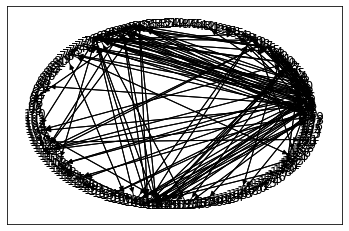

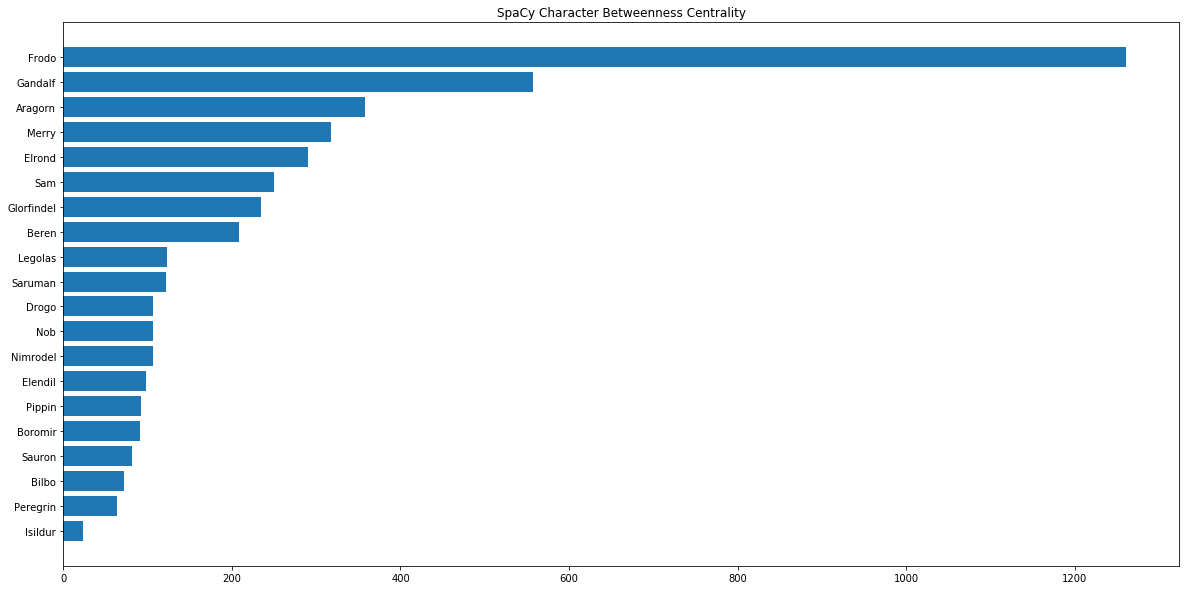

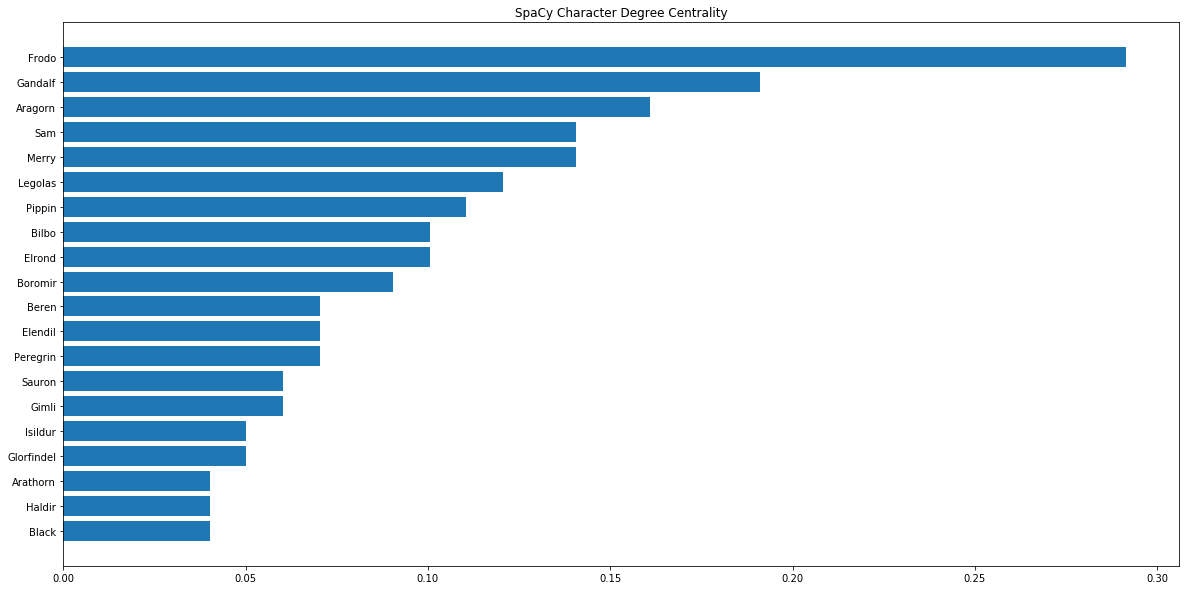

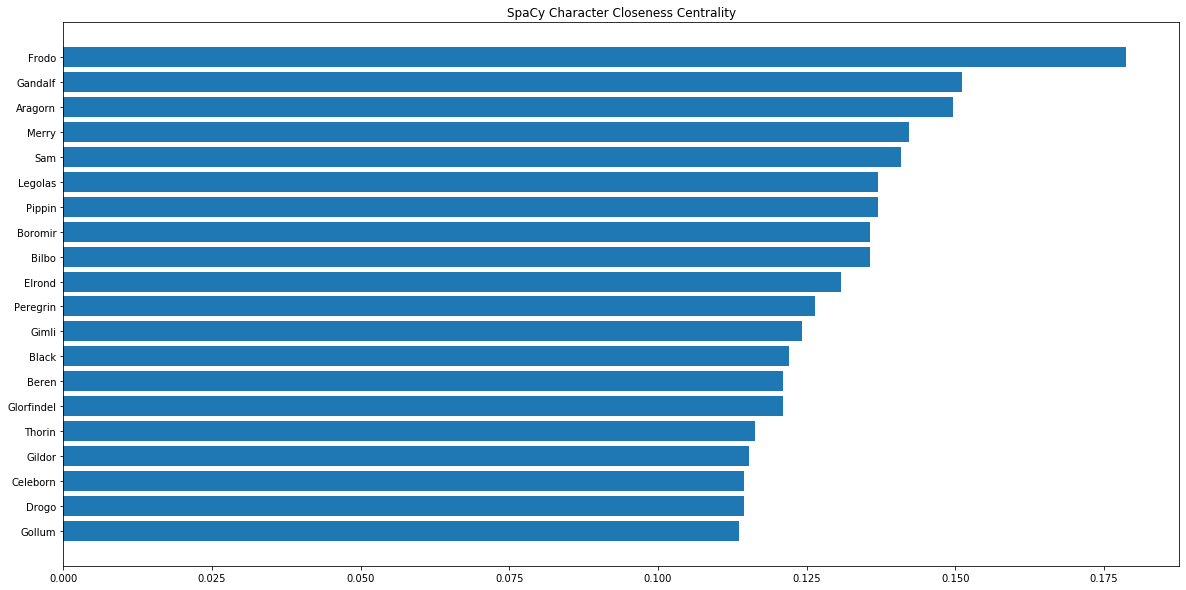

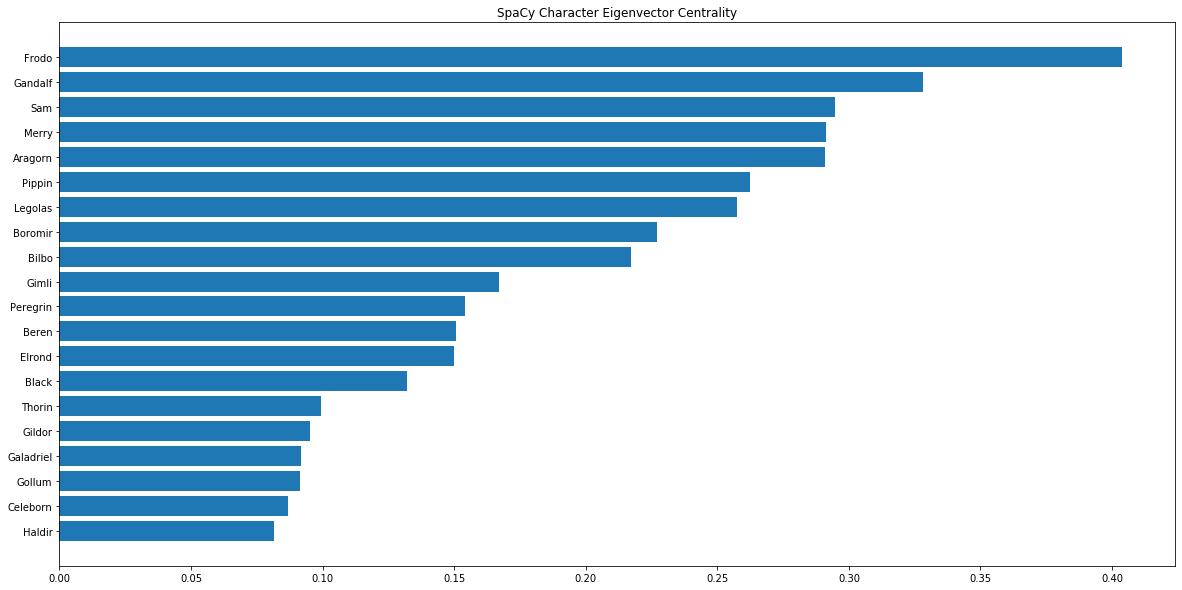

In [0]:
#Trained SpaCy Model results
co_mat, word_mapping = create_co_occurence_matrix(characters.values, words_in_sentences)
visualize(co_mat, word_mapping, 20)

In [42]:
#Comparing Accuracy Metrics 
base_acc = round(np.sum(characters['text'].isin(full_characters['first']))/len(characters)*100,2)
trained_acc = np.sum(trained_characters.isin(full_characters['first']))/len(trained_characters)*100
print('Base Spacy Model Accuracy: {}%'.format(base_acc))
print('Trained Spacy Model Accuracy: {}%'.format(trained_acc))


Base Spacy Model Accuracy: 10.38%
Trained Spacy Model Accuracy: 43.5%
